In [1]:
from requests import get, post
from web3 import Web3, HTTPProvider
from icecream import ic
import numpy as np
import pandas as pd
import sys
from dotenv import load_dotenv
import os
import json
import matplotlib.pyplot as plt
from datetime import datetime
import spice

[Aave Tx Scroll- User Position Overtime](https://dune.com/queries/4017492) | 4017492

[Aave Tx Base- User Position Overtime](https://dune.com/queries/4017643) | 4017643

In [6]:
from dune_client.types import QueryParameter
from dune_client.client import DuneClient
from dune_client.query import QueryBase

# Explicitly specify the path to .env file using forward slashes
load_dotenv(dotenv_path='../.env')

dune = DuneClient(
    api_key=os.getenv('DUNE_API_KEY2'),
    base_url="https://api.dune.com",
    request_timeout=5000 # request will time out after 300 seconds
)


In [7]:
# Query the latest result into a dataframe
scroll_query_result = dune.get_latest_result_dataframe(4017492)

In [20]:
# Query the latest result into a dataframe
base_query_result = dune.get_latest_result_dataframe(4017643)

### Scroll df Construction

In [10]:
# scroll_query_result['collateral_usd'] = scroll_query_result['aWETH']*scroll_query_result['WETH_price'] + scroll_query_result['aUSDC']*scroll_query_result['USDC_price'] + scroll_query_result['awstETH']*scroll_query_result['wstETH_price'] + scroll_query_result['aweETH']*scroll_query_result['weETH_price']
# scroll_query_result['debt_usd'] = scroll_query_result['dWETH']*scroll_query_result['WETH_price'] + scroll_query_result['dUSDC']*scroll_query_result['USDC_price'] + scroll_query_result['dwstETH']*scroll_query_result['wstETH_price'] + scroll_query_result['dweETH']*scroll_query_result['weETH_price']
# scroll_query_result['LTV'] = scroll_query_result['debt_usd'] / scroll_query_result['collateral_usd']

# Define lists of collateral and debt columns and their corresponding price columns
scroll_collateral_cols = ['aWETH', 'aUSDC', 'awstETH', 'aweETH']
scroll_debt_cols = ['dWETH', 'dUSDC', 'dwstETH', 'dweETH']
scroll_price_cols = ['WETH_price', 'USDC_price', 'wstETH_price', 'weETH_price']

# Calculate 'collateral_usd' using vectorized operations
scroll_query_result['collateral_usd'] = (scroll_query_result[scroll_collateral_cols] * scroll_query_result[scroll_price_cols].values).sum(axis=1)

# Calculate 'debt_usd' using vectorized operations
scroll_query_result['debt_usd'] = (scroll_query_result[scroll_debt_cols] * scroll_query_result[scroll_price_cols].values).sum(axis=1)

# Calculate 'LTV' safely by avoiding division by zero
scroll_query_result['LTV'] = scroll_query_result['debt_usd'] / scroll_query_result['collateral_usd'].replace(0, pd.NA)

# Optional: Fill or handle any NaNs resulting from division by zero
scroll_query_result['LTV'] = scroll_query_result['LTV'].fillna(0)


In [11]:
scroll_query_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78811 entries, 0 to 78810
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   day             78811 non-null  object 
 1   user            78811 non-null  object 
 2   aWETH           78811 non-null  float64
 3   aUSDC           78811 non-null  float64
 4   awstETH         78811 non-null  float64
 5   aweETH          78811 non-null  float64
 6   dWETH           78811 non-null  float64
 7   dUSDC           78811 non-null  float64
 8   dwstETH         78811 non-null  float64
 9   dweETH          78811 non-null  float64
 10  WETH_price      78811 non-null  float64
 11  USDC_price      78811 non-null  float64
 12  wstETH_price    78811 non-null  float64
 13  weETH_price     78811 non-null  float64
 14  collateral_usd  78811 non-null  float64
 15  debt_usd        78811 non-null  float64
 16  LTV             78811 non-null  float64
dtypes: float64(15), object(2)
memor

In [12]:
# export the results_df to a csv file
scroll_query_result.to_csv('scroll_query_result.csv', index=False)

### Base df Construction

In [21]:
base_query_result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67390 entries, 0 to 67389
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   day           67390 non-null  object 
 1   user          67390 non-null  object 
 2   aWETH         67390 non-null  float64
 3   acbETH        67390 non-null  float64
 4   aUSDbC        67390 non-null  float64
 5   awstETH       67390 non-null  float64
 6   aUSDC         67390 non-null  float64
 7   aweETH        67390 non-null  float64
 8   dWETH         67390 non-null  float64
 9   dcbETH        67390 non-null  float64
 10  dUSDbC        67390 non-null  float64
 11  dwstETH       67390 non-null  float64
 12  dUSDC         67390 non-null  float64
 13  dweETH        67390 non-null  float64
 14  WETH_price    67390 non-null  float64
 15  cbETH_price   67390 non-null  float64
 16  USDbC_price   67390 non-null  float64
 17  wstETH_price  67390 non-null  float64
 18  USDC_price    67390 non-nu

In [22]:
# Define lists of collateral and debt columns and their corresponding price columns
base_collateral_cols = ['aWETH', 'acbETH','aUSDbC','awstETH','aUSDC', 'aweETH']
base_debt_cols = ['dWETH', 'dcbETH','dUSDbC','dwstETH','dUSDC', 'dweETH']
base_price_cols = ['WETH_price', 'cbETH_price','USDbC_price','wstETH_price','USDC_price', 'weETH_price']

# Calculate 'collateral_usd' using vectorized operations
base_query_result['collateral_usd'] = (base_query_result[base_collateral_cols] * base_query_result[base_price_cols].values).sum(axis=1)

# Calculate 'debt_usd' using vectorized operations
base_query_result['debt_usd'] = (base_query_result[base_debt_cols] * base_query_result[base_price_cols].values).sum(axis=1)

# Calculate 'LTV' safely by avoiding division by zero
base_query_result['LTV'] = base_query_result['debt_usd'] / base_query_result['collateral_usd'].replace(0, pd.NA)

# Optional: Fill or handle any NaNs resulting from division by zero
base_query_result['LTV'] = base_query_result['LTV'].fillna(0) 


In [24]:
# export the results_df to a csv file
base_query_result.to_csv('base_query_result.csv', index=False)

## Plotting

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

def create_time_series_heatmap(df, date_column, value_column, num_bins=20, vmin=0, vmax=1):
    # Convert date column to datetime if it's not already
    df[date_column] = pd.to_datetime(df[date_column])
    
    # Get the date range
    start_date = df[date_column].min().date()
    end_date = df[date_column].max().date()
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Create bins for the y-axis
    bins = np.linspace(vmin, vmax, num_bins + 1)
    
    # Initialize the heatmap data
    heatmap_data = np.zeros((num_bins, len(date_range)))
    
    # Populate the heatmap data
    for i, date in enumerate(date_range):
        day_data = df[df[date_column].dt.date == date.date()][value_column]
        day_data = day_data[(day_data >= vmin) & (day_data <= vmax)]  # Filter outliers
        if not day_data.empty:
            hist, _ = np.histogram(day_data, bins=bins)
            heatmap_data[:, i] = hist
    
    # Create the heatmap
    fig, ax = plt.subplots(figsize=(20, 10))
    sns.heatmap(heatmap_data, ax=ax, cmap='viridis', cbar_kws={'label': 'Frequency'})
    
    # Customize the plot
    ax.set_title('LTV Time-Series Heatmap')
    ax.set_xlabel('Date')
    ax.set_ylabel('LTV')
    
    # Set x-axis ticks to show dates
    num_ticks = 50
    tick_locations = np.linspace(0, len(date_range) - 1, num_ticks, dtype=int)
    ax.set_xticks(tick_locations)
    ax.set_xticklabels([date_range[i].strftime('%Y-%m-%d') for i in tick_locations], rotation=90, ha='right')
    
    # Set y-axis ticks to show LTV values for each bin
    ax.set_yticks(np.arange(num_bins) + 0.5)
    ax.set_yticklabels([f'{bins[i]:.2f}-{bins[i+1]:.2f}' for i in range(num_bins)], rotation=0, fontsize=8)
    
    # plt.tight_layout()
    plt.show()
    return fig, ax


## Scroll Chain

### Time vs User LTV

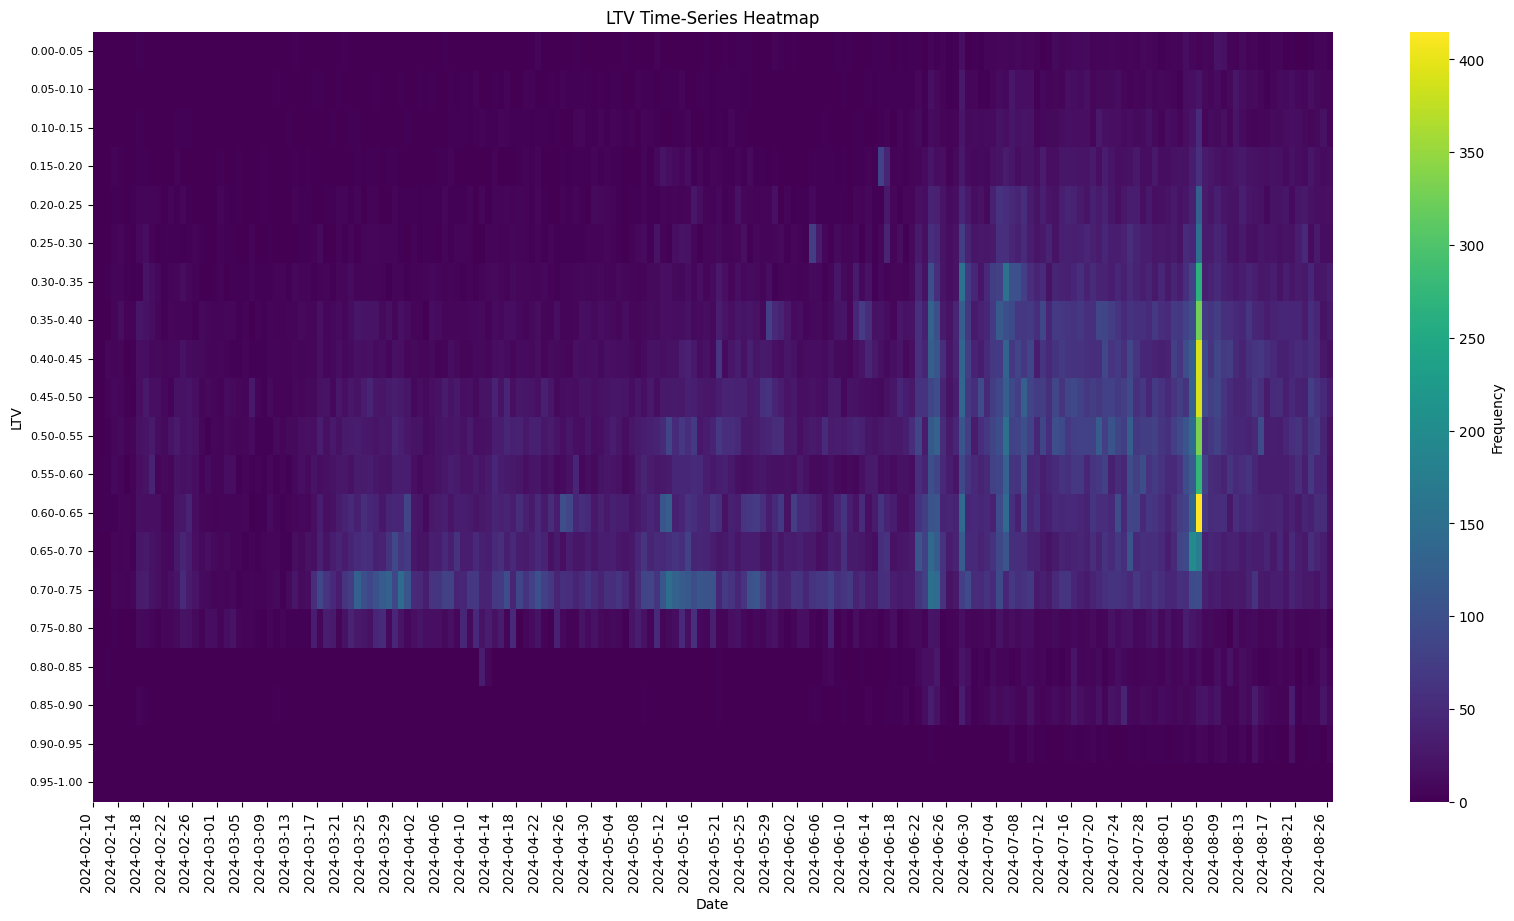

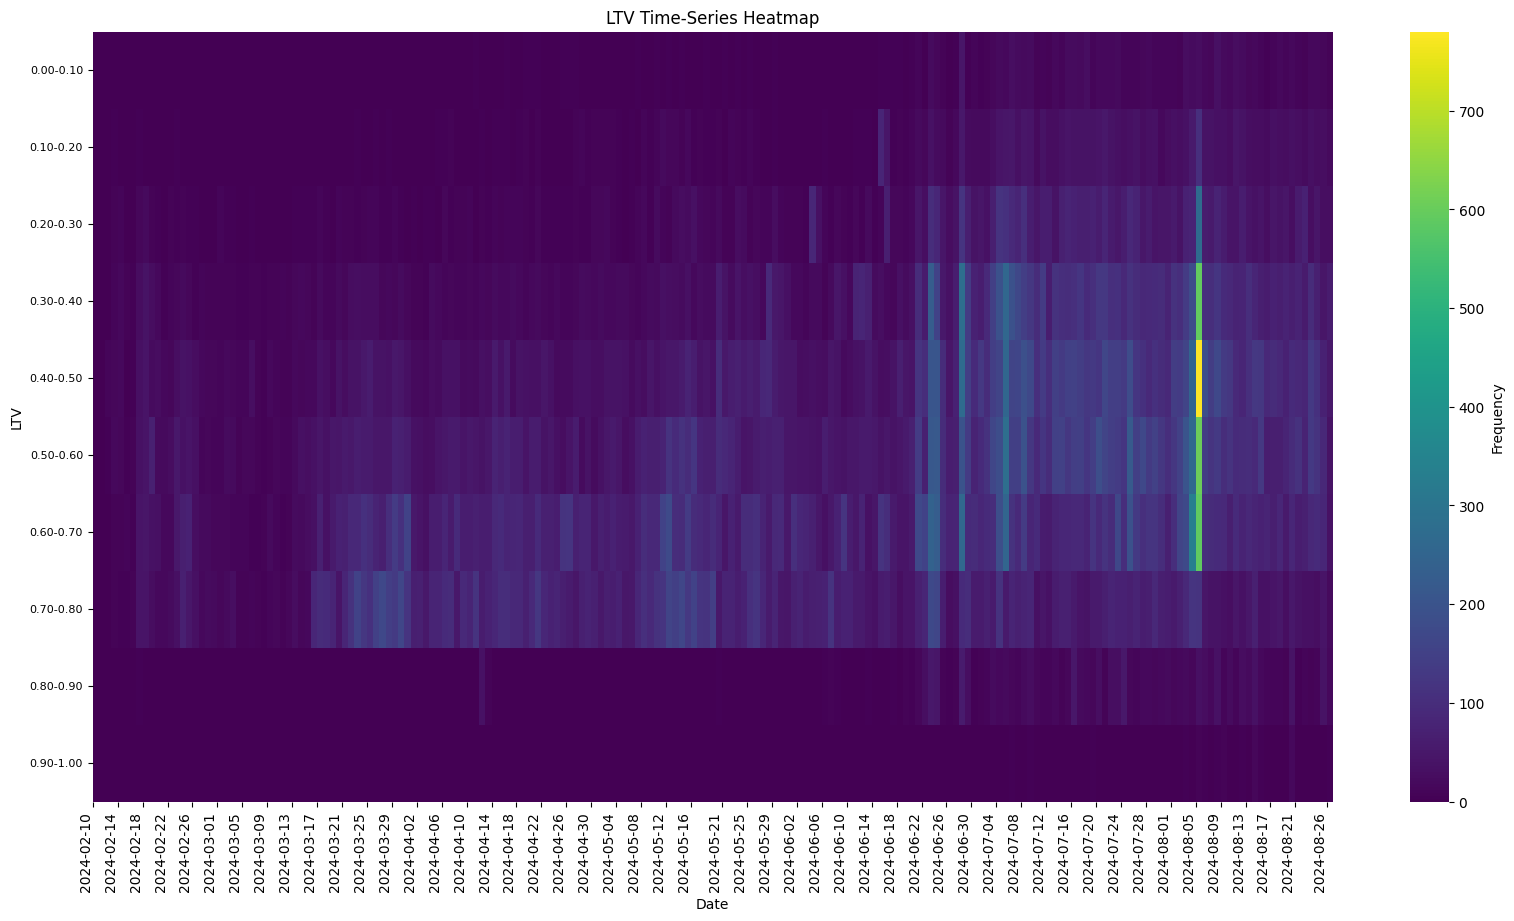

In [19]:
fig, ax = create_time_series_heatmap(scroll_query_result, 'day', 'LTV', num_bins=20)

fig, ax = create_time_series_heatmap(scroll_query_result, 'day', 'LTV', num_bins=10)

### Time vs User LTV for Correlated Pairs 

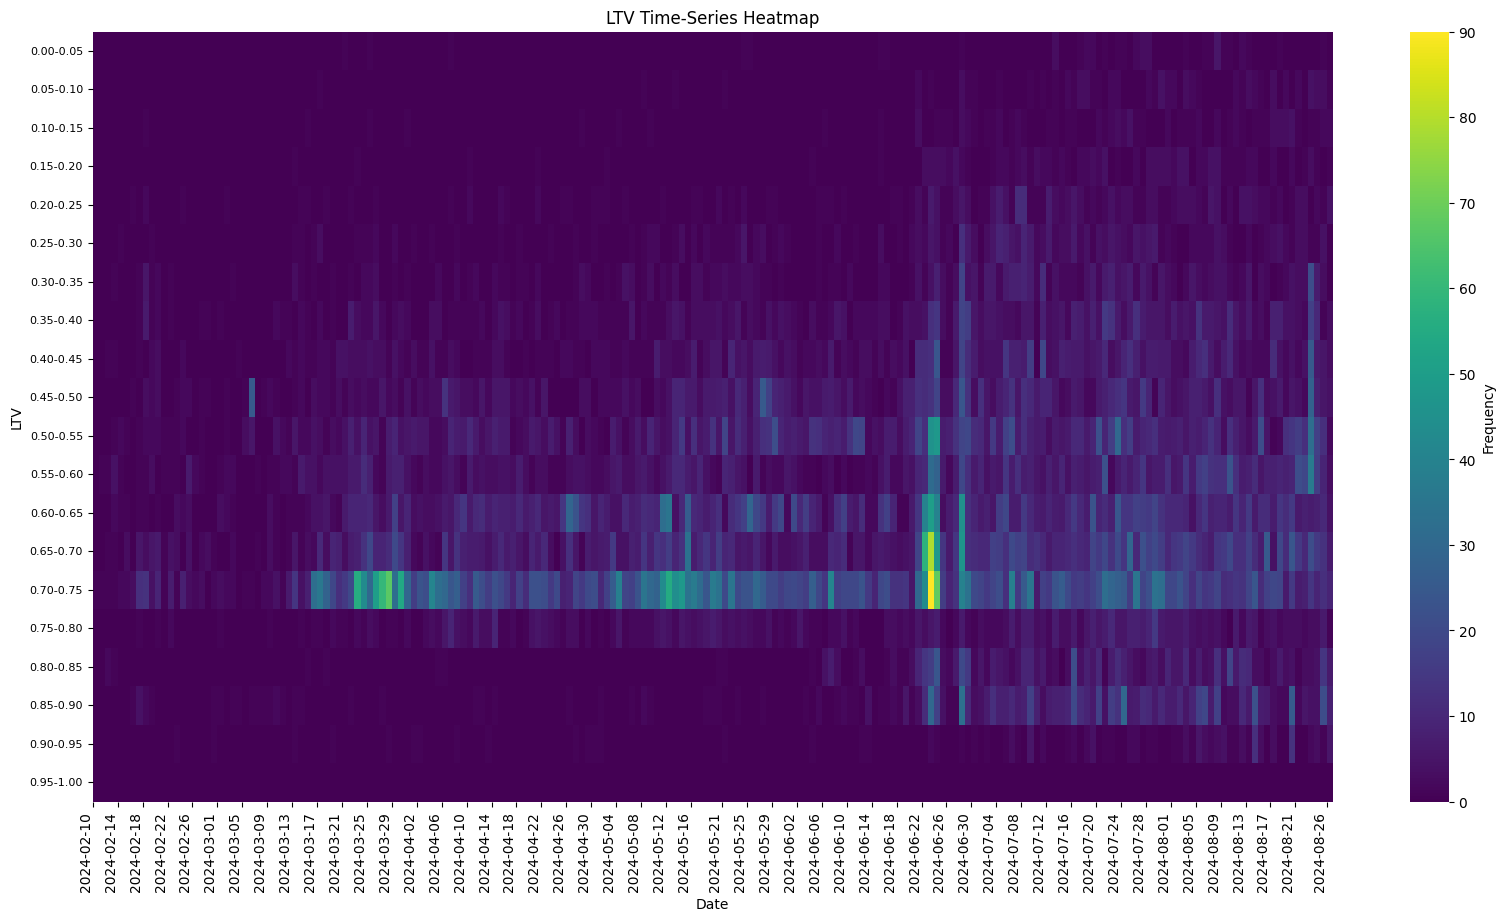

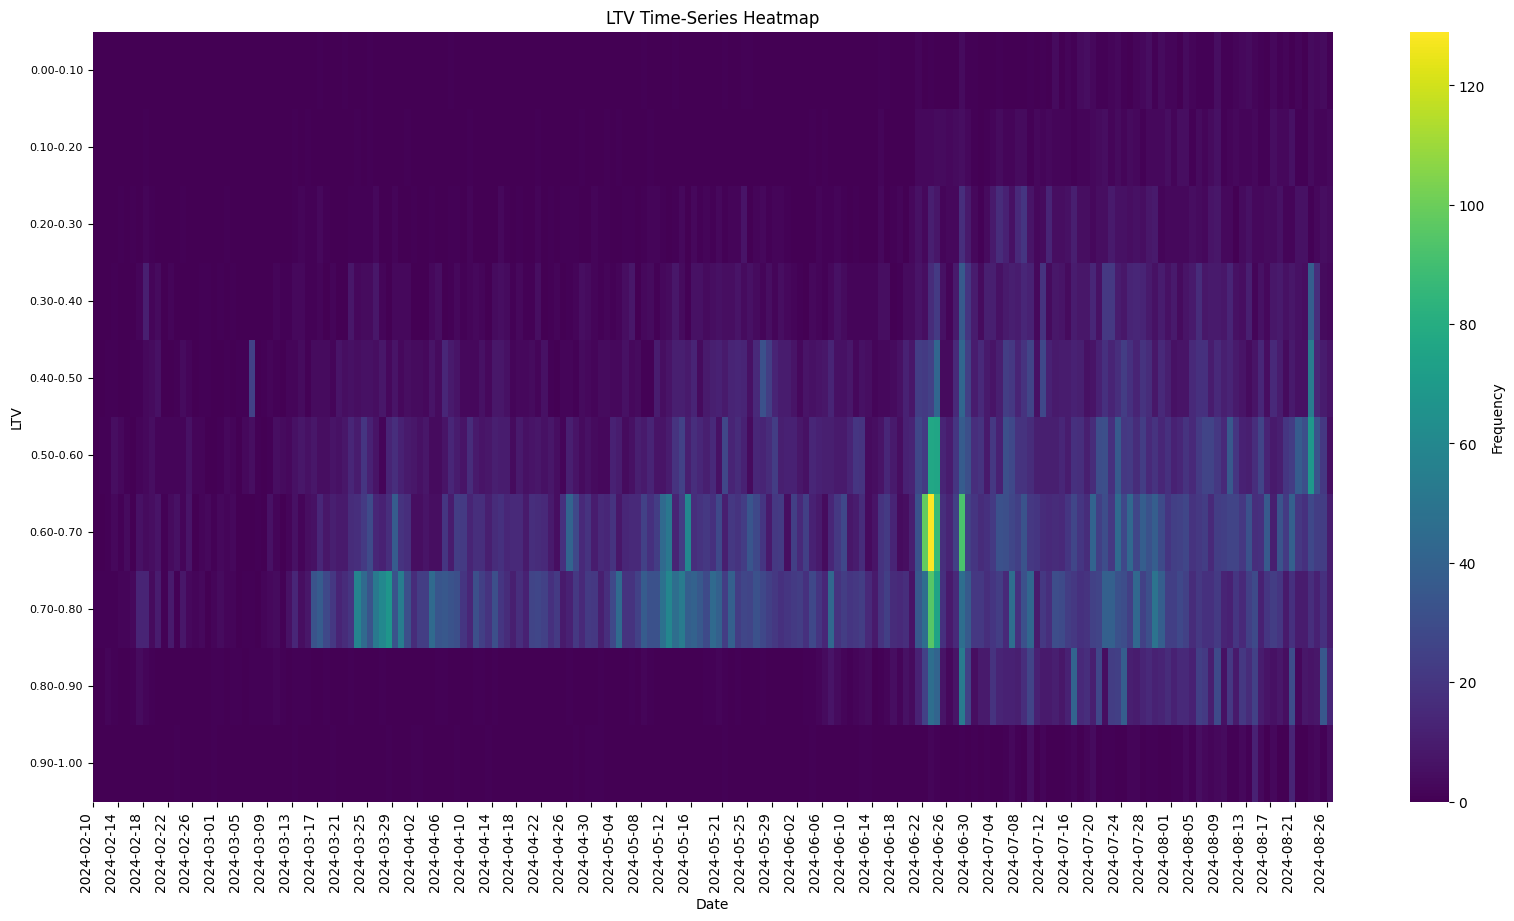

In [17]:
# Creating a copy of the filtered DataFrame to avoid the warning
filtered_scroll_query_result = scroll_query_result[(scroll_query_result['dUSDC'] == 0) & (scroll_query_result['aUSDC'] == 0)].copy()

# Now safely modify the 'day' column
filtered_scroll_query_result['day'] = pd.to_datetime(filtered_scroll_query_result['day'])

fig, ax = create_time_series_heatmap(filtered_scroll_query_result, 'day', 'LTV', num_bins=20)

fig, ax = create_time_series_heatmap(filtered_scroll_query_result, 'day', 'LTV', num_bins=10)

## Base Chain

### Time vs User LTV

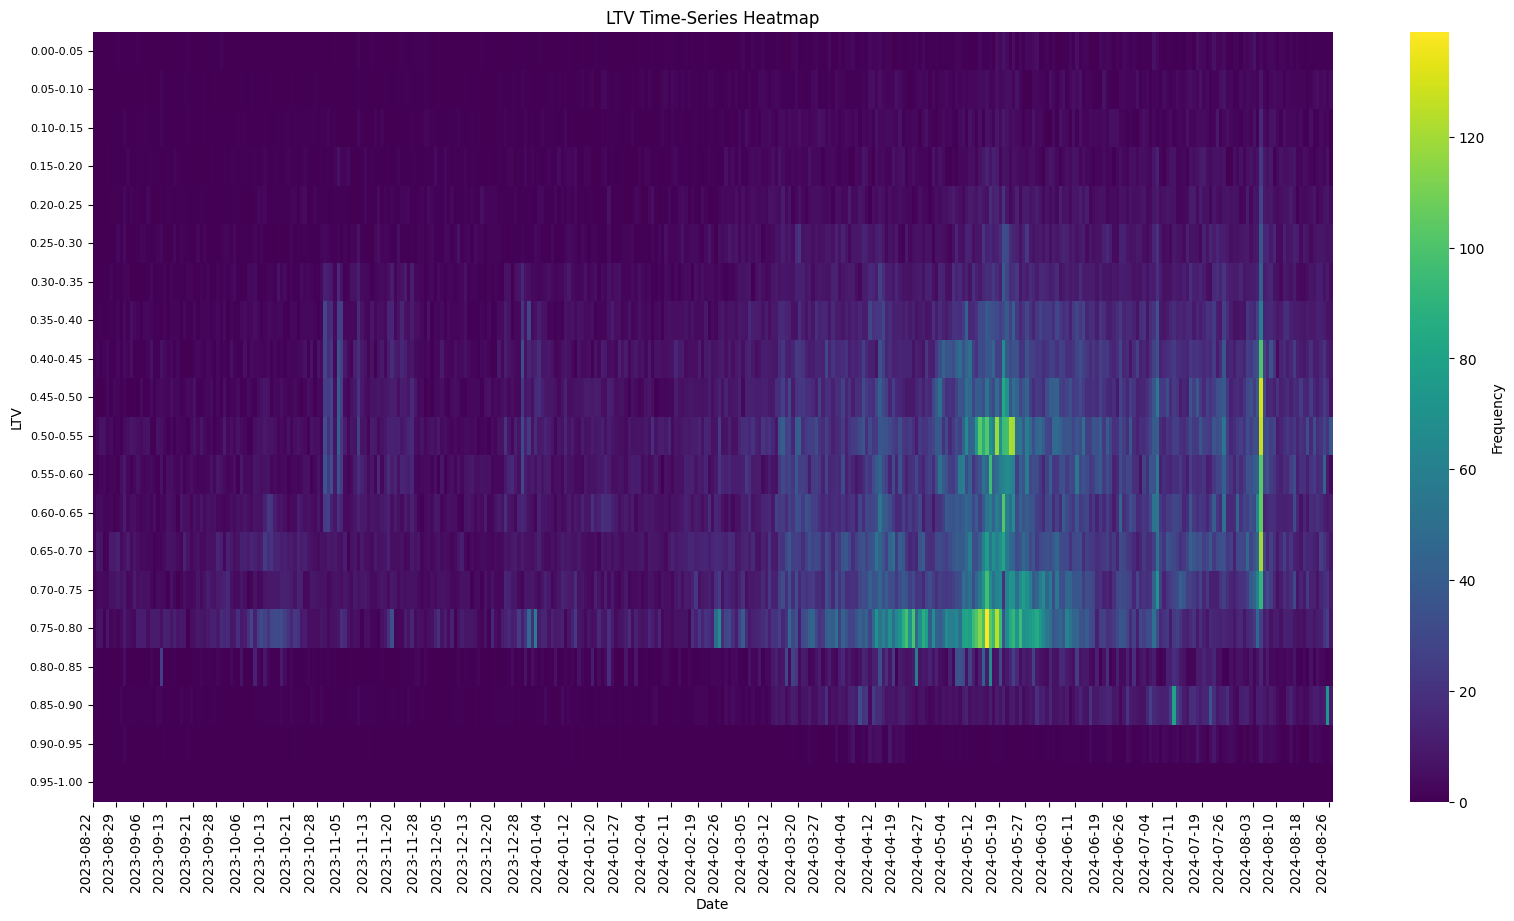

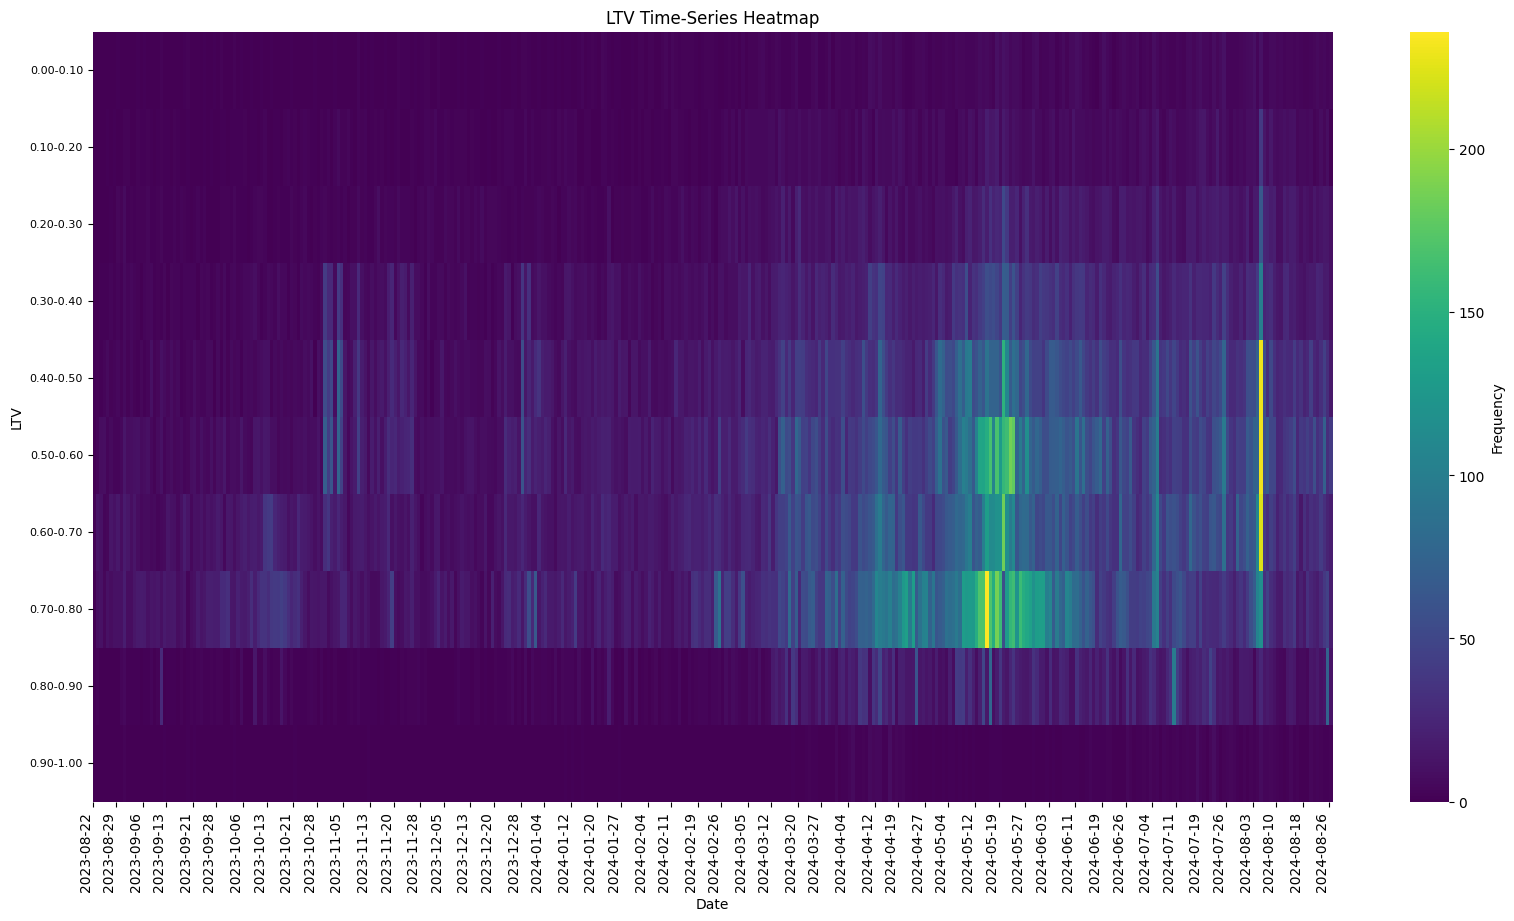

In [23]:
fig, ax = create_time_series_heatmap(base_query_result, 'day', 'LTV', num_bins=20)

fig, ax = create_time_series_heatmap(base_query_result, 'day', 'LTV', num_bins=10)

### Time vs User LTV Correlated Pair

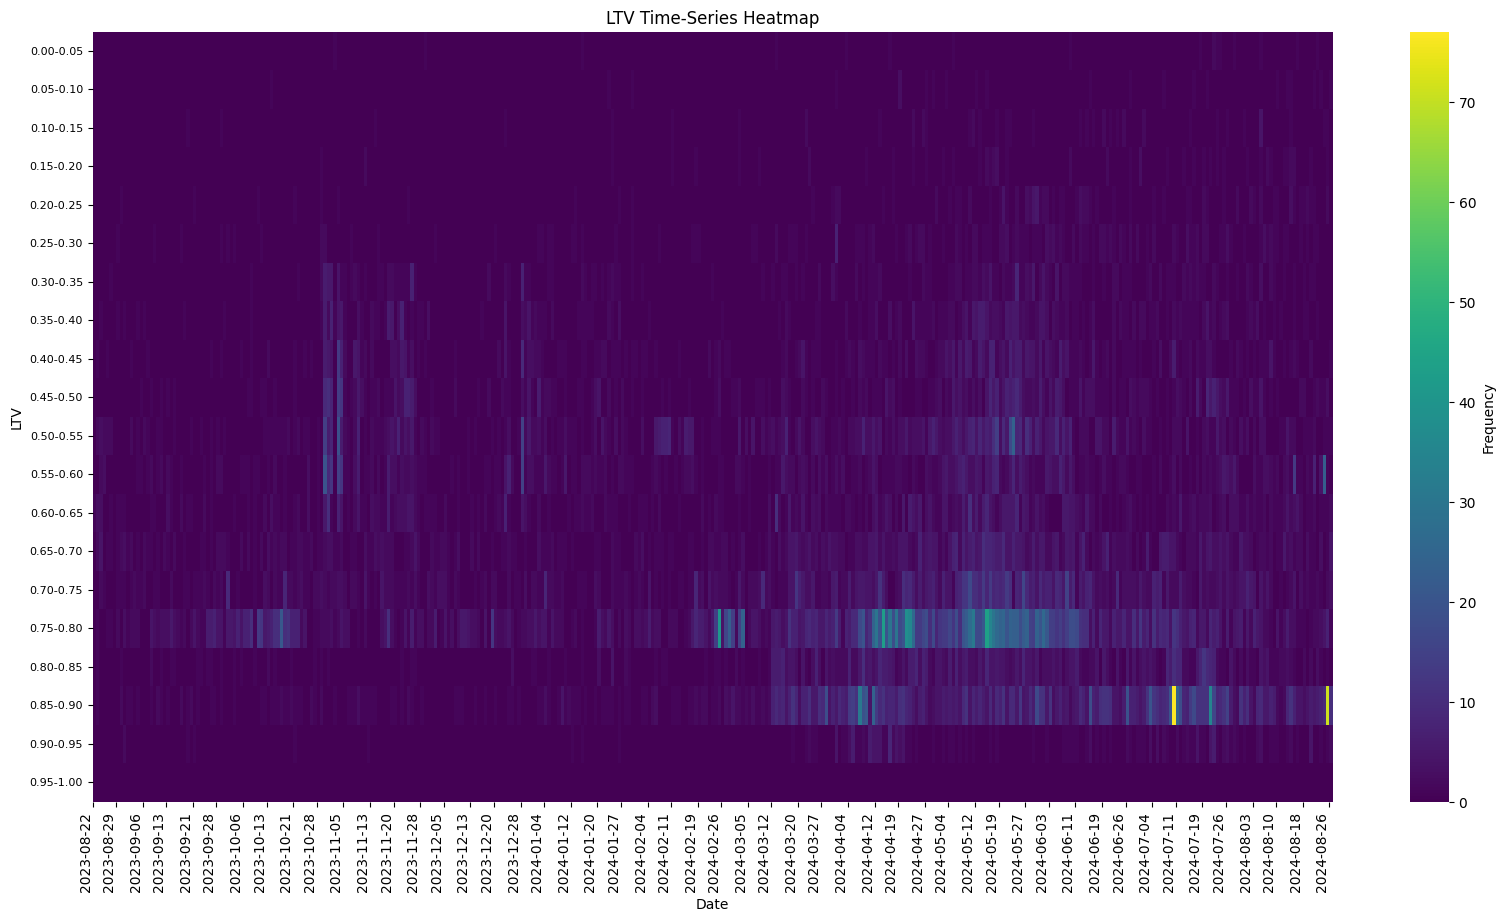

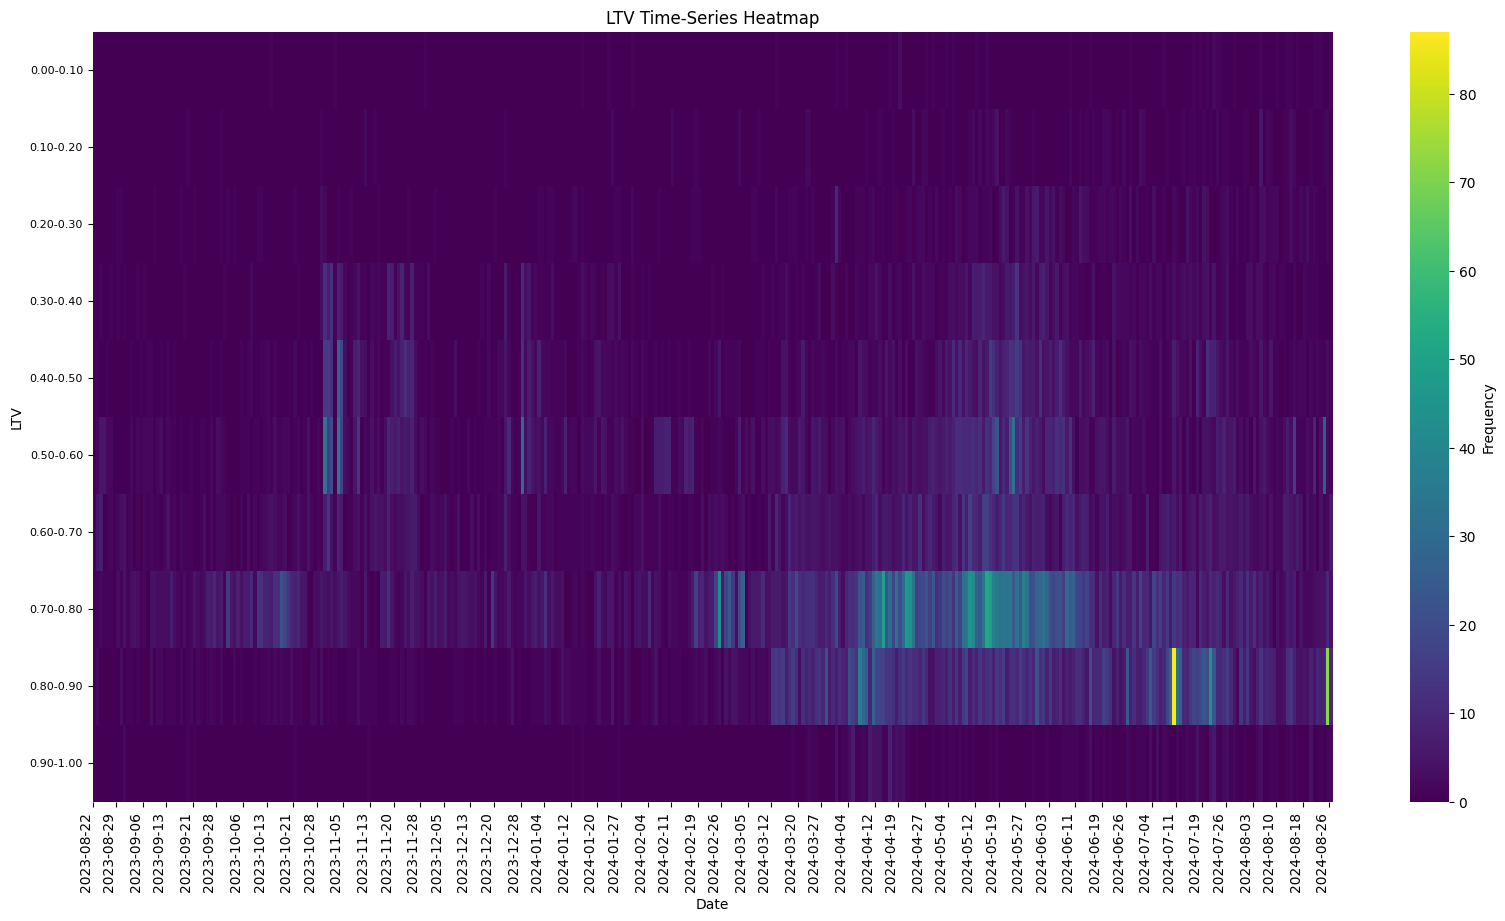

In [26]:
# Creating a copy of the filtered DataFrame to avoid the warning
filtered_base_query_result = base_query_result[(base_query_result['dUSDC'] == 0) & (base_query_result['aUSDC'] == 0) & (base_query_result['dUSDbC'] == 0) & (base_query_result['aUSDbC'] == 0)].copy()


# Now safely modify the 'day' column
filtered_base_query_result['day'] = pd.to_datetime(filtered_base_query_result['day'])

fig, ax = create_time_series_heatmap(filtered_base_query_result, 'day', 'LTV', num_bins=20)

fig, ax = create_time_series_heatmap(filtered_base_query_result, 'day', 'LTV', num_bins=10)

## Misc

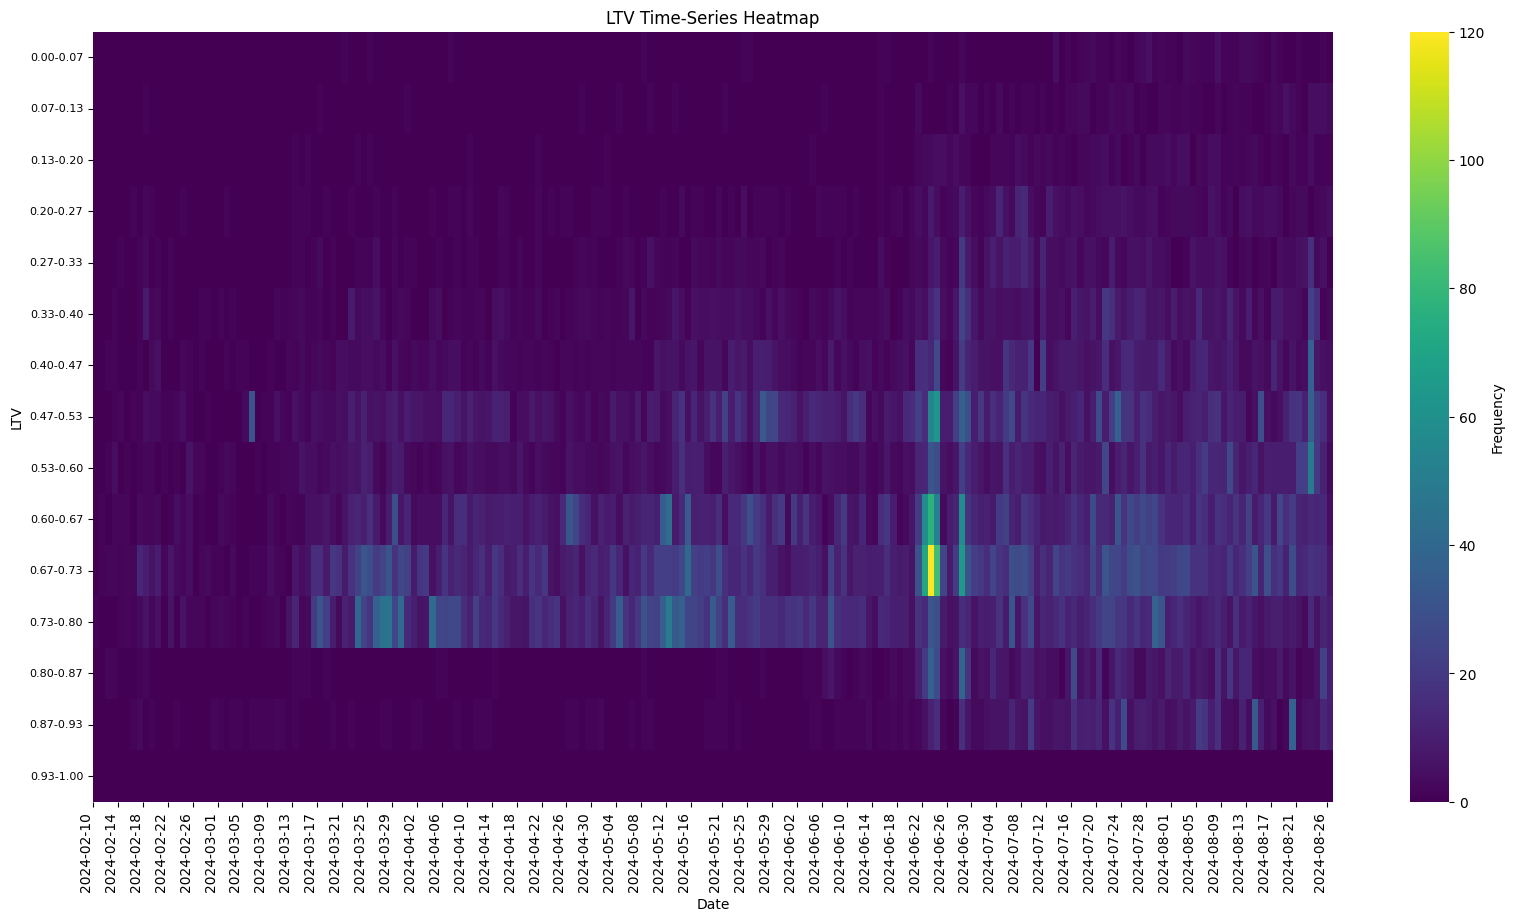

In [31]:
fig, ax = create_time_series_heatmap(filtered_scroll_query_result, 'day', 'LTV', num_bins=15)